# FMU Parameter Optimization
Tutorial by Tobias Thummerer

## License

In [1]:
# Copyright (c) 2021 Tobias Thummerer, Lars Mikelsons
# Licensed under the MIT license. 
# See LICENSE (https://github.com/thummeto/FMI.jl/blob/main/LICENSE) file in the project root for details.

## Introduction to the example
This example shows how a parameter optimization can be set up for a FMU. The goal is to fit FMU parameters (and initial states), so that a reference trajectory is fit as good as possible.

Note, that this tutorial covers optimization *without* gradient information. Basically, *FMI.jl* supports gradient based optimization, too.

## Other formats
Besides, this [Jupyter Notebook](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/parameter_optimization.ipynb) there is also a [Julia file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/parameter_optimization.jl) with the same name, which contains only the code cells and for the documentation there is a [Markdown file](https://github.com/thummeto/FMI.jl/blob/examples/examples/src/parameter_optimization.md) corresponding to the notebook.  

## Getting started

### Installation prerequisites
|     | Description                       | Command                   |
|:----|:----------------------------------|:--------------------------|
| 1.  | Enter Package Manager via         | ]                         |
| 2.  | Install FMI via                   | add FMI                   | 
| 3.  | Install FMIZoo via                | add FMIZoo                | 
| 4.  | Install Optim  via                | add Optim                 | 
| 5.  | Install Plots  via                | add Plots                 | 

## Code section

To run the example, the previously installed packages must be included. 

In [2]:
# imports
using FMI
using FMIZoo
using Optim
using Plots
using DifferentialEquations

### Simulation setup

Next, the start time and end time of the simulation are set.

In [3]:
tStart = 0.0
tStop = 5.0
tStep = 0.1
tSave = tStart:tStep:tStop

0.0:0.1:5.0

### Import FMU

In the next lines of code the FMU model from *FMIZoo.jl* is loaded and the information about the FMU is shown.

In [4]:
# we use an FMU from the FMIZoo.jl
fmu = loadFMU("SpringPendulum1D", "Dymola", "2022x"; type=:ME)
info(fmu)

#################### Begin information for FMU ####################
	Model name:			SpringPendulum1D
	FMI-Version:			2.0
	GUID:				{fc15d8c4-758b-48e6-b00e-5bf47b8b14e5}
	Generation tool:		Dymola Version 2022x (64-bit), 2021-10-08
	Generation time:		2022-05-19T06:54:23Z
	Var. naming conv.:		structured
	Event indicators:		0
	Inputs:				0
	Outputs:			0
	States:				2


		33554432 ["mass.s"]
		33554433 ["mass.v"]
	Parameters:			7
		16777216 ["mass_s0"]
		16777217 ["mass_v0"]
		16777218 ["fixed.s0"]
		16777219 ["spring.c"]
		16777220 ["spring.s_rel0"]
		16777221 ["mass.m"]
		16777222 ["mass.L"]
	Supports Co-Simulation:		true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
		Var. com. steps:	true
		Input interpol.:	true
		Max order out. der.:	1
	Supports Model-Exchange:	true
		Model identifier:	SpringPendulum1D
		Get/Set State:		true
		Serialize State:	true
		Dir. Derivatives:	true
##################### End information for FMU #####################


Now, the optimization objective (the function to minimize) needs to be defined. In this case, we just want to do a simulation and compare it to a regular `sin` wave.

In [5]:
s_tar = 1.0 .+ sin.(tSave)

# a function to simulate the FMU for given parameters
function simulateFMU(p)
    s0, v0, c, m = p # unpack parameters: s0 (start position), v0 (start velocity), c (spring constant) and m (pendulum mass)

    # pack the parameters into a dictionary
    paramDict = Dict{String, Any}()
    paramDict["spring.c"] = c 
    paramDict["mass.m"] = m

    # pack the start state
    x0 = [s0, v0]

    # simulate with given start stae and parameters
    sol = simulate(fmu, (tStart, tStop); x0=x0, parameters=paramDict, saveat=tSave)

    # get state with index 1 (the position) from the solution
    s_res = getState(sol, 1; isIndex=true) 

    return s_res
end

# the optimization objective
function objective(p)
    s_res = simulateFMU(p)

    # return the position error sum between FMU simulation (s_res) and target (s_tar)
    return sum(abs.(s_tar .- s_res))    
end

objective (generic function with 1 method)

Now let's see how far we are away for our guess parameters:

In [6]:
s0 = 0.0 
v0 = 0.0
c = 1.0
m = 1.0 
p = [s0, v0, c, m]

obj_before = objective(p) # not really good!

54.432324541060666

Let's have a look on the differences:

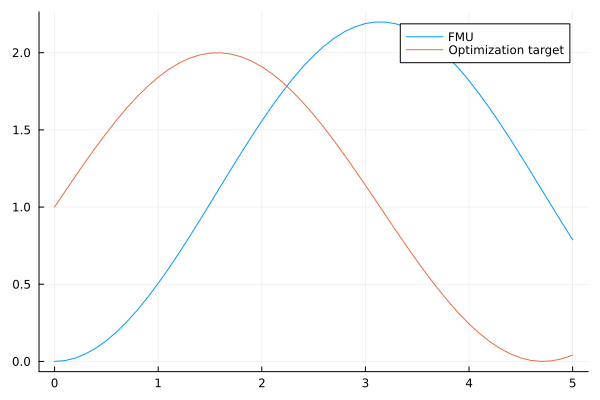

In [7]:
s_fmu = simulateFMU(p); # simulate the position

plot(tSave, s_fmu; label="FMU")
plot!(tSave, s_tar; label="Optimization target")

Not that good. So let's do a bit of optimization!

In [8]:
opt = Optim.optimize(objective, p; iterations=250) # do max. 250 iterations
obj_after = opt.minimum # much better!
p_res = opt.minimizer # the optimized parameters

4-element Vector{Float64}:
 1.001403274413198
 0.9774221156554082
 0.06320990027854359
 0.05504288604531428

Looks promising, let's have a look on the results plot:

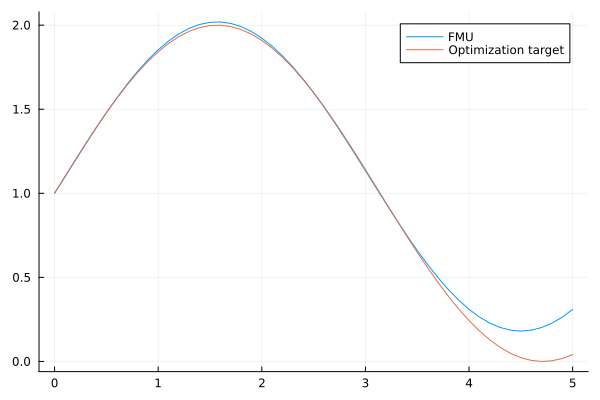

In [9]:
s_fmu = simulateFMU(p_res); # simulate the position

plot(tSave, s_fmu; label="FMU")
plot!(tSave, s_tar; label="Optimization target")

Actually a pretty fit! If you have higher requirements, check out the *Optim.jl* library.

In [10]:
unloadFMU(fmu)

### Summary

This tutorial showed how a parameter (and start value) optimization can be performed on a FMU with a gradient free optimizer. This tutorial will be extended soon to further show how convergence for large parameter spaces can be improoved!